In [1]:
import pandas as pd

import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
from nltk import SnowballStemmer, PorterStemmer, LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

import warnings
warnings.filterwarnings("ignore")


In [2]:
raw = pd.read_csv("/workspaces/codespaces-jupyter/data/train.csv")
raw.head()
raw['message'][4]

"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight"

In [3]:
raw['message'] = raw['message'].str.lower()
tt = TweetTokenizer()
raw['message']= raw['message'].apply(tt.tokenize)
raw['message'][4]

['rt',
 '@soynoviodetodas',
 ':',
 "it's",
 '2016',
 ',',
 'and',
 'a',
 'racist',
 ',',
 'sexist',
 ',',
 'climate',
 'change',
 'denying',
 'bigot',
 'is',
 'leading',
 'in',
 'the',
 'polls',
 '.',
 '#electionnight']

In [4]:
#stopwords_list = stopwords.words('english')
def remove_stop_words(tokens):    
    return [t for t in tokens if t not in stopwords.words('english')]
raw['message'] = raw['message'].apply(remove_stop_words)

In [5]:
#raw["message"] = raw["message"].apply(''.join)
raw_stopped = raw.copy()
raw_stopped['message'][4]

['rt',
 '@soynoviodetodas',
 ':',
 '2016',
 ',',
 'racist',
 ',',
 'sexist',
 ',',
 'climate',
 'change',
 'denying',
 'bigot',
 'leading',
 'polls',
 '.',
 '#electionnight']

In [6]:
raw_stopped["message"] = raw_stopped["message"].apply(' '.join)
raw_stopped['message'] = raw_stopped['message'].str.replace('\d+', '')
raw_stopped['message'][4]

'rt @soynoviodetodas :  , racist , sexist , climate change denying bigot leading polls . #electionnight'

In [7]:
raw_stopped.head()

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,rt @rawstory : researchers say three years act...,698562
3,1,#todayinmaker # wired : pivotal year war clim...,573736
4,1,"rt @soynoviodetodas : , racist , sexist , cli...",466954


In [8]:
def remove_RT(column_name):
    return re.sub(r'^rt[\s]+', '',column_name)

In [9]:
raw_stopped['message']= raw_stopped['message'].apply(remove_RT)
raw_stopped['message'][4]

'@soynoviodetodas :  , racist , sexist , climate change denying bigot leading polls . #electionnight'

In [10]:
def remove_handels(post):
    return re.sub('@[^\s]+',' ',post)

raw_stopped['message']= raw_stopped['message'].apply(remove_handels)
raw_stopped.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief think carbon dioxide ma...,625221
1,1,like lack evidence anthropogenic global warming,126103
2,2,: researchers say three years act climate ch...,698562
3,1,#todayinmaker # wired : pivotal year war clim...,573736
4,1,": , racist , sexist , climate change denyin...",466954
5,1,worth read whether believe climate change http...,425577
6,1,: mike pence ’ believe global warming smokin...,294933
7,1,: six big things today fight climate change ...,992717
8,1,yo nephew inconsolable . wants die old age l...,664510
9,1,: offense … like … believe … global warming ...,260471


In [11]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
raw_stopped['message'] = raw_stopped['message'].replace(to_replace = pattern_url,value = " ", regex = True)
print(raw_stopped["message"][2])

  : researchers say three years act climate change ’ late    …


In [12]:
def remove_hashtages(post):
    return re.sub('#[^\s]+',' ',post)

raw_stopped['message']= raw_stopped['message'].apply(remove_hashtages)
print(raw_stopped["message"][4])

  :  , racist , sexist , climate change denying bigot leading polls .  


In [13]:
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])


raw_stopped["message"] = raw_stopped["message"].apply(remove_punctuation)
print(raw_stopped["message"][4])

     racist  sexist  climate change denying bigot leading polls   


In [14]:
raw_stopped['message'] = raw_stopped['message'].str.split()
# steming
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def mbti_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words] 

#raw_stopped['message'] = raw_stopped['message'].apply(mbti_lemma, args=(lemmatizer))


stemmer = SnowballStemmer("english")
raw_stopped['message'] = raw_stopped['message'].apply(lambda x: [stemmer.stem(y) for y in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
raw_stopped['message'][4]

['racist', 'sexist', 'climat', 'chang', 'deni', 'bigot', 'lead', 'poll']

In [16]:
sentiment_counts = raw_stopped['sentiment'].value_counts()
print(sentiment_counts)

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64


Text(0, 0.5, 'Count')

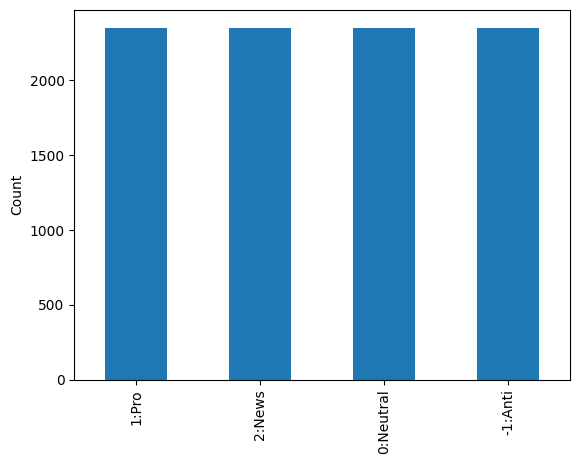

In [17]:
sentiment_counts = raw_stopped['sentiment'].value_counts()
sentiment_labels = {
    '-1': '-1:Anti',
    '0': '0:Neutral',
    '1': '1:Pro',
    '2': '2:News'
}

# Assuming there are an odd number of sentiment classes
middle_class_index = len(sentiment_counts) // 2
middle_class = sentiment_counts.index[middle_class_index]
middle_count = sentiment_counts.loc[middle_class]

oversampled_raw = pd.concat([raw_stopped[raw_stopped['sentiment'] == middle_class]] +
                            [raw_stopped[raw_stopped['sentiment'] == sentiment].sample(middle_count, replace=True) 
                             for sentiment in sentiment_counts.index if sentiment != middle_class])


ax = oversampled_raw['sentiment'].value_counts().plot(kind='bar')
ax.set_xticklabels([sentiment_labels.get(str(sentiment), 'Unknown') for sentiment in sentiment_counts.index])
ax.set_ylabel('Count')


In [18]:
sentiment_counts = oversampled_raw['sentiment'].value_counts()
print(sentiment_counts)

 0    2353
 1    2353
 2    2353
-1    2353
Name: sentiment, dtype: int64


In [19]:
oversampled_raw

,sentiment,message,tweetid
19,0,"[calum, tweet, abt, reunitingish, w, cast, see...",547924
22,0,"[also, met, guy, let, us, truth, climat, chang...",67545
30,0,"[scientist, denounc, climat, chang, choic]",365051
39,0,"[’, dealt, simpl, issu, like, climat, chang, e...",403368
43,0,"[win, probabl, bullshit, man, saw, nba, final,...",326916
...,...,...,...
4606,-1,"[hottest, year, record, us, suit, global, warm...",925076
1705,-1,"[climat, chang, chines, hoax, man]",547368
6512,-1,"[need, worri, climat, chang, europ, time, musl...",650964
8807,-1,"[wail, global, warm, alway, default, posit, th...",51154


In [20]:
raw_stopped['message'][4]

['racist', 'sexist', 'climat', 'chang', 'deni', 'bigot', 'lead', 'poll']

In [21]:
y = oversampled_raw['sentiment']

# features
X =oversampled_raw.drop(['sentiment'], axis=1)

In [22]:
X["message"]

19      [calum, tweet, abt, reunitingish, w, cast, see...
22      [also, met, guy, let, us, truth, climat, chang...
30             [scientist, denounc, climat, chang, choic]
39      [’, dealt, simpl, issu, like, climat, chang, e...
43      [win, probabl, bullshit, man, saw, nba, final,...
                              ...                        
4606    [hottest, year, record, us, suit, global, warm...
1705                   [climat, chang, chines, hoax, man]
6512    [need, worri, climat, chang, europ, time, musl...
8807    [wail, global, warm, alway, default, posit, th...
9785    [hey, obama, global, warm, real, come, cold, o...
Name: message, Length: 9412, dtype: object

In [23]:
X["message"] = X["message"].apply(' '.join)

In [24]:
X["message"]

19      calum tweet abt reunitingish w cast see repli ...
22      also met guy let us truth climat chang gay peo...
30                   scientist denounc climat chang choic
39      ’ dealt simpl issu like climat chang energi po...
43      win probabl bullshit man saw nba final that kn...
                              ...                        
4606    hottest year record us suit global warm agenda...
1705                         climat chang chines hoax man
6512    need worri climat chang europ time muslim kill...
8807    wail global warm alway default posit thing lik...
9785          hey obama global warm real come cold outsid
Name: message, Length: 9412, dtype: object

In [25]:
# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
X_train =  X_train.drop(['tweetid'], axis=1)
X_test_id =  pd.DataFrame(X_test["tweetid"].reset_index(drop= True))
X_test =  X_test.drop(['tweetid'], axis=1)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

betterVect = CountVectorizer(stop_words='english', 
                             min_df=2, 
                             max_df=0.5,
                             ngram_range=(1, 1))

In [28]:

X_train_fitted = betterVect.fit_transform(X_train["message"])
X_test_counts = betterVect.transform(X_test["message"])

In [29]:
X_train_fitted

<7529x3799 sparse matrix of type '<class 'numpy.int64'>'
	with 51187 stored elements in Compressed Sparse Row format>

In [30]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt = dt.fit(X_train_fitted, y_train)

print(f"Train Score: {dt.score(X_train_fitted, y_train)}")
print(f"Test Score: {dt.score(X_test_counts , y_test)}")

Train Score: 0.994820029220348
Test Score: 0.7020711630377058


In [31]:
dt_predections = dt.predict(X_test_counts)
dt_predections

array([-1, -1,  1, ...,  1,  1,  0])

In [32]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, dt_predections)

array([[422,  35,  20,  13],
       [ 62, 265,  83,  53],
       [ 36,  77, 280,  68],
       [ 12,  56,  46, 355]])

In [33]:
print(classification_report(y_test,dt_predections, target_names=['-1:Anti','0:Neutral','1:Pro','2:News']))

              precision    recall  f1-score   support

     -1:Anti       0.79      0.86      0.83       490
   0:Neutral       0.61      0.57      0.59       463
       1:Pro       0.65      0.61      0.63       461
      2:News       0.73      0.76      0.74       469

    accuracy                           0.70      1883
   macro avg       0.70      0.70      0.70      1883
weighted avg       0.70      0.70      0.70      1883



In [34]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth": [2,7,50],
    "min_samples_leaf": [10,20,25,30,35,45,50]
}

In [35]:
grid = GridSearchCV(DecisionTreeClassifier(), params)
grid.fit(X_train_fitted, y_train)

grid.best_params_

{'max_depth': 50, 'min_samples_leaf': 10}

In [36]:
dt2 = DecisionTreeClassifier(**grid.best_params_)

dt2.fit(X_train_fitted, y_train)

print(f"Train Accuracy: {round(dt2.score(X_train_fitted, y_train), 3)}")
print(f"Test Accuracy: {round(dt2.score(X_test_counts, y_test), 3)}")

Train Accuracy: 0.56
Test Accuracy: 0.501


In [37]:
dt2_predictions = dt2.predict(X_test_counts)

print(classification_report(y_test,dt2_predictions, target_names=['-1:Anti','0:Neutral','1:Pro','2:News']))

              precision    recall  f1-score   support

     -1:Anti       0.67      0.45      0.54       490
   0:Neutral       0.37      0.73      0.49       463
       1:Pro       0.56      0.35      0.43       461
      2:News       0.65      0.47      0.55       469

    accuracy                           0.50      1883
   macro avg       0.56      0.50      0.50      1883
weighted avg       0.56      0.50      0.50      1883



In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
raw2 = raw_stopped
raw2['message']=raw2['message'].apply(' '.join)

tfidf_matrix = tfidf_vectorizer.fit_transform(raw2['message'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df

,aaa,aaaaaaaaaaa,aaaaaand,aaaaand,aaaand,aan,ab,abaixoassinado,abandon,abbot,...,より,スタリん時代のソ連や毛沢東の文化大革命並のサイエンスに政治的介入だ,名詞,地球温暖化会議,報告書は,欧州が最も大きく地球温暖化の影響を受けていると警告しています,気候変動,申請書のアブストラクトに,米国政府はある研究者に連絡して,ｎｈｋラジオ英会話
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15816,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
import pickle

pickle.dump(dt_predections, open("dt_predections.pkl", "wb"))
pickle.dump(betterVect, open("betterVect.pkl", "wb"))